# TM10007 Assignment -- ECG data


# Introduction to the notebook

This jupyter notebook contains the code used for our Machine Learning setup. The notebook contains 4 sections with subsections, which can be collapsed to keep the workspace tidy. The subsections are listed below with a short description

1. Setup code - Contains code segments to load the patient data, plot the data and divide the data up into two distinct groups for training and testing.
2. Getting to know the material - Contains functions that are used for each step in the machine learning process. Only walks through these steps for the training dataset. Please make sure to run segments 1.1 and 1.3 before executing this segment.
3. Crossvalidation (pipeline) - Contains two code fields that were used to optimize the setup of the neural network and the different pipeline configurations. Please make sure to run segments 1.1 and 1.3 before executing this segment.
4. Putting it together - Contains code segments to configure the used pipeline, execute this setup once and perform repeated splits, returning the performance of the model when executed multiple times. Please make sure to run segments 1.1, 1.3 and 2.1 due 2.4, as these segments define functions used in this segment.

# 1. Setup code

## 1.1 Imports and obtain ECG data

In [1]:
# Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from statistics import mean
import warnings
import zipfile
import os
import pandas as pd
import numpy as np

In [2]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

# Extract zip file
with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

# Read ECG data CSV file
data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

# Print characteristics of the dataframe to terminal
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

Cloning into 'tm10007_ml'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 38 (delta 11), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (38/38), done.
The number of samples: 827
The number of columns: 9001


## 1.2 Plot the input data (optional)

The code below plots the input data in a figure, categorized by diseased (red) or healthy (green).

Amount of diseased patients: 146


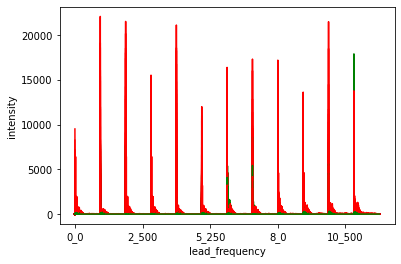

In [3]:
# Plot data
f = pd.Series(np.arange(0,11.749,0.001))
for patient in data.index:
  y = data.loc[patient]
  color = ('red','green')[data.loc[patient,'label']]
  y.plot.line(x=f,color=color,xlabel='lead_frequency',ylabel='intensity')
print(f'Amount of diseased patients: {sum(data["label"])}')

The figure above displays the intensity of the signal for sample ```a_b```, where ```a``` stands for the observed ECG lead and ```b``` stands for the observed frequency.

## 1.3 Split up the data into a training set and a test set.



In [4]:
def split_data(inputdata: pd.DataFrame, p_training:float = 0.85):
  # Takes a dataframe as input and returns two randomly split subsets of this dataframe, with ratio p_training
  assert p_training >= 0 and p_training <= 1
  training_data = inputdata.sample(frac=p_training)
  testing_data = inputdata.drop(training_data.index)
  return training_data,testing_data

# obtain the training and test datasets
[training_data,test_data] = split_data(data)

# Print characteristics
print(f'The number of samples, columns in training dataset: {len(training_data.index)}, {len(training_data.columns)}')
print(f'The number of samples, columns in test dataset: {len(test_data.index)}, {len(test_data.columns)}')

The number of samples, columns in training dataset: 703, 9001
The number of samples, columns in test dataset: 124, 9001


# 2. Getting to know the material
Please make sure to run sections 1.1 and 1.3 before running the code in this section.

## 2.1 Initialize parameters
Parameters used for the step-by-step run through the pipeline. Contains the same values as segment 4.1 to initialize the functions with the right values for repeated split, but may be altered to test different configurations

In [37]:
# Scaling method
SCALING_METHOD = 'STANDARDIZATION'  # 'STANDARDIZATION' or 'NORMALIZATION'

# Selection method
SELECTION_METHOD = 'PCA'            # 'UNIVARIATE' or 'PCA'

## Selection - Univariate selection
UNI_NUM_FEATURES = 90

# Classification method
CLASSIFICATION_METHOD = 'NN'        # 'NN' or 'NB'

# Classifier - Neural Network
SIZE = (20)
LR = 'adaptive'
ACTIVATION = 'logistic'
ALPHA = 0.05
SOLVER = 'adam'

## 2.2 Scaling
Finds and applies scaling objects. Choice between normalization and standardization. 

### Find normalization object and apply normalization

In [38]:
def find_normalizer(input_data):
  # Takes input data and returns a MinMaxScaler that is fitted to the input data
  input_norm = input_data.copy().drop(columns=['label'])
  # numerical features
  num_cols = list(input_norm.columns.values.tolist())
  # fit scaler on training data
  norm = MinMaxScaler().fit(input_norm)
  return norm

norm = find_normalizer(training_data)

Apply normalisation function

In [39]:
def apply_normalisation(input_data,norm):
  # Returns the input data as scaled by the supplied MinMaxScaler
  scaled_data = input_data.copy().drop(columns=['label'])
  # transform training data
  scaled_data = norm.transform(scaled_data)
  # plot normalized training data
  scaled_data = pd.DataFrame(scaled_data,
                             columns=list(input_data.columns.values.tolist())[:-1],
                             index=input_data.index)
  return scaled_data

normalized_data = apply_normalisation(training_data, norm)

### Find standardization object and apply normalization

In [40]:
def find_standardizer(input_data):
  # Takes input data and returns a StandardScaler that is fitted to the input data
  input_stand = input_data.copy().drop(columns=['label'])
  # numerical features
  num_cols = list(input_stand.columns.values.tolist())[:-1]
  scale = StandardScaler().fit(input_stand)
  return scale

standardizer = find_standardizer(training_data)

Apply standardization function

In [41]:
def apply_standardization(input_data,scale):
  # Returns the input data as scaled by the supplied MinMaxScaler
  standardized_data = input_data.copy().drop(columns=['label'])
  standardized_data = scale.transform(standardized_data)
  standardized_data = pd.DataFrame(standardized_data, 
                                   columns=list(input_data.columns.values.tolist())[:-1],
                                   index=input_data.index)
  return standardized_data

standardized_data = apply_standardization(training_data,standardizer)

### Functions to generalize Scaling step

In [42]:
def find_scaler(training_data,method=SCALING_METHOD):
  # Takes a training dataset and finds a SCALING_METHOD fitted on the input data
  if (method=='STANDARDIZATION'):
    scaler = find_standardizer(training_data)
  elif (method=='NORMALIZATION'):
    scaler = find_normalizer(training_data)
  else:
    print('Specified method is invalid')
  return scaler

scaler = find_scaler(training_data)

In [43]:
def apply_scaler(input_data, scaler, method=SCALING_METHOD):
  # Returns the input data as transformed by the supplied scaling object
  if (method=='STANDARDIZATION'):
    output_data = apply_standardization(input_data,scaler)
  elif (method=='NORMALIZATION'):
    output_data = apply_normalisation(input_data,scaler)
  else:
    print('Specified method is invalid')
  labels = input_data['label']
  output_data = output_data.join(labels)
  return output_data

train_scaled = apply_scaler(training_data, scaler)

## 2.3 Feature selection
Finds and applies feature selection or extraction. Choice between PCA and Univariate testing

### Univariate testing via ANOVA

In [44]:
def find_univariate(train_scaled):
  # Returns a SelectKBest object as fitted on the input data, and the training data as transformed by the selector object
  selector = SelectKBest(k=UNI_NUM_FEATURES)
  train_selected = selector.fit_transform(train_scaled.copy().drop(columns=['label']),train_scaled['label'])
  train_selected = pd.DataFrame(train_selected,
                                index=train_scaled.index)
  train_selected = train_selected.join(train_scaled['label'])
  return train_selected, selector

train_selected, selector = find_univariate(train_scaled)

In [45]:
def apply_UNI(test_scaled, selector):
  # Returns the test data as transformed by the supplied SelectKBest object.
  output_dataset = selector.transform(test_scaled.copy().drop(columns=['label']))
  output_dataset = pd.DataFrame(output_dataset,
                                index=test_scaled.index)
  output_dataset = output_dataset.join(test_scaled['label'])
  return output_dataset

### Dimensionality reduction by PCA

In [46]:
def find_principal_components(input_data):
  # returns a PCA object fitted on the input data, and the input data as transformed by the PCA object.
  # delete column 'label'
  train_scaled = input_data.copy().drop(columns=['label'])

  # Find an appropriate number of components using a for loop
  for n in range(101,301,10):
    # create two dimensional PCA
    pca = PCA(n_components=n)
    principal_components = pca.fit_transform(train_scaled)
    # create dataframe
    principal_components_df = pd.DataFrame(data = principal_components,index=input_data.index)
    # print the explained variation
    #print(f'{n} components -> total explained variation: {sum(pca.explained_variance_ratio_)}')
    if sum(pca.explained_variance_ratio_) >= 0.95:
      break 
  
  labels = input_data['label']
  principal_components_df = principal_components_df.join(labels)
  cumsum = np.cumsum(pca.explained_variance_ratio_)
  return principal_components_df, pca

train_selected, selector = find_principal_components(train_scaled)


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

In [47]:
def apply_PCA(inputdata, pca):
  outputdata = inputdata.copy().drop(columns=['label'])
  outputdata = pca.transform(outputdata)
  outputdata = pd.DataFrame(outputdata,index=inputdata.index)
  outputdata = outputdata.join(inputdata['label'])
  return outputdata

### Generalize Feature Selection step


In [48]:
def find_selector(train_input,method=SELECTION_METHOD):
  # Return selector fitted on the input and the input as transformed by the selector
  if (method == 'UNIVARIATE'):
    #print('feature selection by univariate z-test')
    train_selected, selector = find_univariate(train_input)
  elif (method == 'PCA'):
    #print('feature selection by PCA')
    train_selected, selector = find_univariate(train_input)
  return train_selected, selector

train_selected,selector = find_selector(train_scaled,'UNIVARIATE')

In [49]:
def apply_selector(inputdata,selector,method=SELECTION_METHOD):
  # Transforms the input data using the supplied selector object.
  if (method == 'UNIVARIATE'):
    outputdata = apply_UNI(inputdata,selector)
  elif (method == 'PCA'):
    outputdata = apply_PCA(inputdata,selector)
  return outputdata

## 2.4 Classification
Trains and applies a classifier object. Choice between Naive Bayes and Neural Network

### Naive Bayes classifier

In [50]:
def train_NB(training_set):
  # Return a naive bayes classifier object as trained on the supplied training set.
  # classifier trainen
  x_train = train_selected.copy().drop(columns=['label'])
  y_train = train_selected['label']

  NB = GaussianNB()
  NB = NB.fit(x_train, y_train)
  y_train_predict = NB.predict(x_train)

  accuracy_train = sum(y_train == y_train_predict)/len(y_train)
  print(f'Training set score: {accuracy_train}')
  
  return NB

NB = train_NB(train_selected)

Training set score: 0.8463726884779517


### Neural Network classifier


In [51]:
def train_NN(inputdata):
  # Return a neural network classifier object as trained on the supplied inputdata
  x_train = train_selected.copy().drop(columns=['label'])
  y_train = train_selected['label']

  mlp = MLPClassifier(
      hidden_layer_sizes=SIZE,
      activation=ACTIVATION,
      alpha=ALPHA,
      learning_rate=LR,
      solver=SOLVER
  )
  
  mlp.fit(x_train, y_train)
  return mlp

classifier = train_NN(train_selected)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


### Generalize classifier step

In [52]:
def train_classifier(training_data, method=CLASSIFICATION_METHOD):
  # Train a classifier of choice using the supplied training data.
  if (method == 'NN'):
    return train_NN(training_data)
  elif (method == 'NB'):
    return train_NB(training_data)
  else:
    print("Invalid classification method supplied")

classifier = train_classifier(train_selected)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [53]:
def apply_classifier(inputdata, scaler, method=CLASSIFICATION_METHOD):
  # Return the input data as classified by the supplied scaler object.
  if (method == 'NN' or method == 'NB'):
    return pd.Series(scaler.predict(inputdata.copy().drop(columns=['label'])),
                        index=inputdata.index)
  else:
    print("Invalid classification method supplied")

train_classified = apply_classifier(train_selected, classifier)

# 3. Crossvalidation (pipeline)
Please make sure to run sections 1.1 and 1.3 before running the code in this section.

3.1 Finds the optimal configuration for the neural network for the dataset. 3.2 Performs cross-validation of different pipeline configurations.

Warnings from the neural network are ignored to improve readability.

## 3.1 Neural Network tuning

In [ ]:
def find_NN_parameters(traning_set):
  # Use GridSearchCV to find the optimal configuration of hyperparameters for the neural network for the supplied training dataset.
  # Prints the ideal values for these parameters. Returns a MLPClassifier with the ideal configurations according to the grid search.
  x_train = train_selected.copy().drop(columns=['label'])
  y_train = train_selected['label']

  mlp_gs = MLPClassifier(max_iter=200)

  parameter_space = {
    'hidden_layer_sizes': [10,20,30,40],
    'activation': ['relu', 'logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
  }  
  clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
  clf.fit(x_train, y_train) # X is train samples and y is the corresponding labels

  print('Best parameters found:\n', clf.best_params_)

  mlp = MLPClassifier(
      hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
      activation=clf.best_params_['activation'],
      alpha=clf.best_params_['alpha'],
      learning_rate=clf.best_params_['learning_rate'],
      solver=clf.best_params_['solver']
  )
  mlp.fit(x_train, y_train)
  #print(f'Training set score: {mlp.score(x_train,y_train)}')

  return mlp

NN = find_NN_parameters(train_selected)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 40, 'learning_rate': 'adaptive', 'solver': 'sgd'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


## 3.2 Crossvalidation

In [ ]:
warnings.filterwarnings('ignore') # suppress warnings from the neural network

x_train = training_data.copy().drop(columns=['label'])
y_train = training_data['label']
sensitivity = make_scorer(recall_score, pos_label=1)
specificity = make_scorer(recall_score, pos_label=0)
scorings = [sensitivity, specificity, "accuracy", "precision"]
CV = 5

# ========= Configure parameters for the pipeline objects ============= #

# Select k best
K = 90

# PCA
N_PCA_STA = 131
N_PCA_NRM = 181

# Neural Network
SIZE = (20)
LR = 'adaptive'
ACTIVATION = 'logistic'
ALPHA = 0.05
SOLVER = 'adam'

# ======= Start pipelines ======= #

# Normalisation - Z-test - NB
classifier_pipeline1 = make_pipeline(MinMaxScaler(), SelectKBest(k=K), GaussianNB())
print("Nor/Z/NB")
for score in scorings:
  print(score, end = ' '),
  print(" : ", end = ' '),
  print(cross_val_score(classifier_pipeline1, x_train, y_train, cv=CV, scoring=score).mean())

# Normalisation - Z-test - NN
classifier_pipeline2 = make_pipeline(MinMaxScaler(), SelectKBest(k=K), MLPClassifier(hidden_layer_sizes=SIZE, learning_rate=LR,
                                                                                     activation=ACTIVATION, alpha=ALPHA, solver=SOLVER))
print("Nor/Z/NN")
for score in scorings:
  print(score, end = ' '),
  print(" : ", end = ' '),
  print(cross_val_score(classifier_pipeline2, x_train, y_train, cv=CV, scoring=score).mean())

# Normalisation - PCA - NB
classifier_pipeline3 = make_pipeline(MinMaxScaler(), PCA(n_components=N_PCA_NRM), GaussianNB())
print("Nor/PCA/NB")
for score in scorings:
  print(score, end = ' '),
  print(" : ", end = ' '),
  print(cross_val_score(classifier_pipeline3, x_train, y_train, cv=CV, scoring=score).mean())

# Normalisation - PCA - NN
classifier_pipeline4 = make_pipeline(MinMaxScaler(), PCA(n_components=N_PCA_NRM), MLPClassifier(hidden_layer_sizes=SIZE, learning_rate=LR,
                                                                                     activation=ACTIVATION, alpha=ALPHA, solver=SOLVER))
print("Nor/PCA/NN")
for score in scorings:
  print(score, end = ' '),
  print(" : ", end = ' '),
  print(cross_val_score(classifier_pipeline4, x_train, y_train, cv=CV, scoring=score).mean())

# Standardisation - Z-test - NB
classifier_pipeline5 = make_pipeline(StandardScaler(), SelectKBest(k=K), GaussianNB())
print("Stan/Z/NB")
for score in scorings:
  print(score, end = ' '),
  print(" : ", end = ' '),
  print(cross_val_score(classifier_pipeline5, x_train, y_train, cv=CV, scoring=score).mean())

# Standardisation - Z-test - NN
classifier_pipeline6 = make_pipeline(StandardScaler(), SelectKBest(k=K), MLPClassifier(hidden_layer_sizes=SIZE, learning_rate=LR,
                                                                                     activation=ACTIVATION, alpha=ALPHA, solver=SOLVER))
print("Stan/Z/NN")
for score in scorings:
  print(score, end = ' '),
  print(" : ", end = ' '),
  print(cross_val_score(classifier_pipeline6, x_train, y_train, cv=CV, scoring=score).mean())

# Standardisation - PCA - NB
classifier_pipeline7 = make_pipeline(StandardScaler(), PCA(n_components=N_PCA_STA), GaussianNB())
print("Stan/PCA/NB")
for score in scorings:
  print(score, end = ' '),
  print(" : ", end = ' '),
  print(cross_val_score(classifier_pipeline7, x_train, y_train, cv=CV, scoring=score).mean())

# Standardisation - PCA - NN
classifier_pipeline8 = make_pipeline(StandardScaler(), PCA(n_components=N_PCA_STA), MLPClassifier(hidden_layer_sizes=SIZE, learning_rate=LR,
                                                                                     activation=ACTIVATION, alpha=ALPHA, solver=SOLVER))
print("Stan/PCA/NN")
for score in scorings:
  print(score, end = ' '),
  print(" : ", end = ' '),
  print(cross_val_score(classifier_pipeline8, x_train, y_train, cv=CV, scoring=score).mean())

warnings.resetwarnings()

Nor/Z/NB
make_scorer(recall_score, pos_label=1)  :  0.35
make_scorer(recall_score, pos_label=0)  :  0.9206896551724139
accuracy  :  0.8207396149949341
precision  :  0.4869285714285714
Nor/Z/NN
make_scorer(recall_score, pos_label=1)  :  0.16266666666666668
make_scorer(recall_score, pos_label=0)  :  0.9879310344827588
accuracy  :  0.8292907801418441
precision  :  0.6233766233766234
Nor/PCA/NB
make_scorer(recall_score, pos_label=1)  :  0.29966666666666664
make_scorer(recall_score, pos_label=0)  :  0.9258620689655173
accuracy  :  0.8079432624113474
precision  :  0.4356612685560054
Nor/PCA/NN
make_scorer(recall_score, pos_label=1)  :  0.227
make_scorer(recall_score, pos_label=0)  :  0.9827586206896551
accuracy  :  0.8449240121580548
precision  :  0.7757575757575758
Stan/Z/NB
make_scorer(recall_score, pos_label=1)  :  0.35
make_scorer(recall_score, pos_label=0)  :  0.9206896551724139
accuracy  :  0.8207396149949341
precision  :  0.4869285714285714
Stan/Z/NN
make_scorer(recall_score, pos_labe

# 4 Putting it together 
Please make sure to run sections 1.1, 1.3 and 2.1 due 2.4 before running this section.

## 4.1 Initialize hyperparameters

In [54]:
# Configuration of the setup
SCALING_METHOD = 'STANDARDIZATION'
SELECTION_METHOD = 'UNIVARIATE'
CLASSIFICATION_METHOD = 'NN'

# Selection - univariate
UNI_NUM_FEATURES = 90

# Selection - PCA
N_PCA_STA = 131
N_PCA_NRM = 181

# Classification - Neural Network
SIZE = (20)
LR = 'adaptive'
ACTIVATION = 'logistic'
ALPHA = 0.05
SOLVER = 'adam'

## 4.2 Run the entire Machine Learning setup once

In [31]:
def find_performance(correct_labels,predicted_labels):
  # Takes correct labels and predicted labels and returns accuracy, sensitivity, specificity and PPV in a pandas Series.
  true_positives = predicted_labels.dot(correct_labels)
  true_negatives = (1-predicted_labels).dot(1-correct_labels)
  false_negatives = sum(correct_labels) - true_positives
  false_positives = sum(1-correct_labels) - true_negatives
  accuracy = (true_positives + true_negatives) / correct_labels.size
  sensitivity = true_positives / (true_positives + false_negatives)
  specificity = true_negatives / (true_negatives + false_positives)
  ppv = true_positives / (true_positives + false_positives)
  return pd.Series([accuracy, sensitivity, specificity, ppv],index=['Accuracy','Sensitivity','Specificity','PPV'])

def run_entire_setup(dataset):
  # Walk through the entire setup once and return performance of the program.
  # split dataset
  train_set,test_set = split_data(dataset)

  # scaling
  scaler = find_scaler(train_set,SCALING_METHOD)
  train_scaled = apply_scaler(train_set,scaler,SCALING_METHOD)
  test_scaled = apply_scaler(test_set,scaler,SCALING_METHOD)

  # Feature selection
  selector = find_selector(train_scaled,SELECTION_METHOD)[1]
  train_selected = apply_selector(train_scaled,selector,SELECTION_METHOD)
  test_selected = apply_selector(test_scaled,selector,SELECTION_METHOD)

  # Classification
  classifier = train_classifier(train_selected,CLASSIFICATION_METHOD)
  train_classified = apply_classifier(train_selected,classifier,CLASSIFICATION_METHOD)
  test_classified = apply_classifier(test_selected,classifier,CLASSIFICATION_METHOD)

  # Performance - accuracy on test set
  correct_labels = test_scaled['label']

  return find_performance(correct_labels, test_classified), scaler, selector, classifier
  

#warnings.filterwarnings("ignore")
[results,scaler,selector,classifier] = run_entire_setup(data)
#warnings.resetwarnings()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Accuracy       0.870968
Sensitivity    0.409091
Specificity    0.970588
PPV            0.750000
dtype: float64

## 4.3 Perform repeated splits

In [36]:
def run_repeated_splits(data,iterations):
  # Run the entire setup iterations times in the dataset
  output = pd.DataFrame()
  for i in range(0,iterations):
    results = run_entire_setup(data)[0]
    output[i] = results
  output['Mean'] = output.mean(axis=1)
  output['Variance'] = output.drop(columns=['Mean']).var(axis=1)
  return output

warnings.filterwarnings("ignore")
display(run_repeated_splits(data,10))
warnings.resetwarnings()


,0,1,2,3,4,5,6,7,8,9,Mean,Variance
Accuracy,0.814516,0.838710,0.830645,0.895161,0.846774,0.782258,0.846774,0.879032,0.846774,0.838710,0.841935,0.000971
Sensitivity,0.280000,0.111111,0.347826,0.578947,0.304348,0.250000,0.500000,0.409091,0.500000,0.300000,0.358132,0.019645
Specificity,0.949495,0.962264,0.940594,0.952381,0.970297,0.910000,0.921569,0.980392,0.921569,0.942308,0.945087,0.000513
PPV,0.583333,0.333333,0.571429,0.687500,0.700000,0.400000,0.578947,0.818182,0.578947,0.500000,0.575167,0.020243
